In [1]:
from __future__ import division

import os
import urllib, cStringIO

import pymongo as pm

import matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import seaborn as sns
sns.set_context('talk')
sns.set_style('white')

import numpy as np
import scipy.stats as stats
import pandas as pd
import json
import re

from PIL import Image
import base64
import sys

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

/Users/megumisano/anaconda/envs/py27/lib/python2.7/site-packages/scipy/spatial/__init__.py:96: ImportWarning: Not importing directory '/Users/megumisano/anaconda/envs/py27/lib/python2.7/site-packages/scipy/spatial/qhull': missing __init__.py
  from .qhull import *
/Users/megumisano/anaconda/envs/py27/lib/python2.7/site-packages/scipy/optimize/_minimize.py:37: ImportWarning: Not importing directory '/Users/megumisano/anaconda/envs/py27/lib/python2.7/site-packages/scipy/optimize/lbfgsb': missing __init__.py
  from .lbfgsb import _minimize_lbfgsb


## setup

In [2]:
# directory & file hierarchy
proj_dir = os.path.abspath('../../..')
analysis_dir = os.getcwd()
results_dir = os.path.join(proj_dir,'results')
plot_dir = os.path.join(results_dir,'plots')
csv_dir = os.path.join(results_dir,'csv')
exp_dir = os.path.abspath(os.path.join(proj_dir,'experiments'))
sketch_dir = os.path.abspath(os.path.join(proj_dir,'sketches'))

## add helpers to python path
if os.path.join(proj_dir,'analysis','python') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'analysis','python'))
    
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)   
    
if not os.path.exists(csv_dir):
    os.makedirs(csv_dir)       
    
# Assign variables within imported analysis helpers
import analysis_helpers as h
if sys.version_info[0]>=3:
    from importlib import reload
reload(h)

<module 'analysis_helpers' from '/Users/megumisano/graphical_conventions/analysis/python/analysis_helpers.pyc'>

In [3]:
# set vars 
auth = pd.read_csv('auth.txt', header = None) # this auth.txt file contains the password for the sketchloop user
pswd = auth.values[0][0]
user = 'sketchloop'
host = 'rxdhawkins.me' ## cocolab ip address

# have to fix this to be able to analyze from local
import pymongo as pm
conn = pm.MongoClient('mongodb://sketchloop:' + pswd + '@127.0.0.1')
db = conn['3dObjects']
coll = db['graphical_conventions']

# which iteration name should we use?
iterationName = 'run4_generalization'

## error tick 
## confusion 
## snapshot of round 1 and by round 8, along the diagonal - pattern of success and failures - representing accuracy invarious ways 
## pixel intensity 
## pipeline for stats - old R markdown notebook - elmer R markdown in analysis archive - mixed effects model 
## interaction pre post between repeated and control 
## svg annoation - expectation of what the - set up stats modeling pipeline 
## tangrams paper - analogous interesting things 

In [4]:
## get total number of stroke and clickedObj events in the collection as a whole
S = coll.find({ '$and': [{'iterationName':iterationName}, {'eventType': 'stroke'}]}).sort('time')
C = coll.find({ '$and': [{'iterationName':iterationName}, {'eventType': 'clickedObj'}]}).sort('time')
print str(S.count()) + ' stroke records in the database.'
print str(C.count()) + ' clickedObj records in the database.'

2417 stroke records in the database.
440 clickedObj records in the database.


In [5]:
## checking to see if certain workers submitted data 
S = coll.find({ '$and': [{'eventType': 'stroke'},{'workerID': 'A1V2P0JYPD7GM6'}]}).sort('time')
C = coll.find({ '$and': [{'eventType': 'clickedObj'},{'workerID': 'A1V2P0JYPD7GM6'}]}).sort('time')
print str(S.count()) + ' stroke records in the database.'
print str(C.count()) + ' clickedObj records in the database.'

0 stroke records in the database.
0 clickedObj records in the database.


## generate group dataframe

In [6]:
## list of researcher mturk worker ID's to ignore
jefan = ['A1MMCS8S8CTWKU','A1MMCS8S8CTWKV','A1MMCS8S8CTWKS']
hawkrobe = ['A1BOIDKD33QSDK']
megsano = ['A1DVQQLVZR7W6I']
researchers = jefan + hawkrobe + megsano 

In [7]:
reload(h)
## get list of all candidate games
games = coll.distinct('gameid')

## get list of complete and valid games
complete_games = h.get_complete_and_valid_games(games,coll,iterationName,researchers=researchers, tolerate_undefined_worker=False)

There are 11 complete games in total.


In [8]:
## check if emailed workers submitted data
for i, game in enumerate(complete_games):
    num_clicks = coll.find({'$and': [{'gameid':game},{'eventType':'clickedObj'},{'iterationName':iterationName}]}).count()
    ## check to make sure there were two real mturk workers participating who were not researchers
    real_workers = False
    viewer = coll.find({'$and': [{'gameid':game},{'eventType':'clickedObj'},{'iterationName':iterationName}]}).distinct('workerId')
    sketcher = coll.find({'$and': [{'gameid':game},{'eventType':'stroke'},{'iterationName':iterationName}]}).distinct('workerId')
    if viewer == 'A1V2P0JYPD7GM6' or sketcher == 'A1V2P0JYPD7GM6':
        print "A1V2P0JYPD7GM6 did complete HIT"
    if viewer == 'A6FE2ZQNFW12V' or sketcher == 'A6FE2ZQNFW12V':
        print "A6FE2ZQNFW12V did complete HIT"

In [9]:
reload(h)

# preprocessing 

TrialNum = []
GameID = []
Condition = []
Target = []
Category = []
Distractor1 = []
Distractor2 = []
Distractor3 = []
Outcome = []
Response = []
Repetition = []
Phase = []
numStrokes = []
drawDuration = [] # in seconds
svgStringLength = [] # sum of svg string for whole sketch
svgStringLengthPerStroke = [] # svg string length per stroke
numCurvesPerSketch = [] # number of curve segments per sketch
numCurvesPerStroke = [] # mean number of curve segments per stroke
svgStringStd = [] # std of svg string length across strokes for this sketch
Outcome = [] #accuracy (True or False)
png=[] # the sketch 
timedOut=[] # True if sketchers didn't draw anything, False o.w.
meanPixelIntensity=[]

y = ['9662-69da656f-884a-416f-a492-59c9f6a13a34']
_complete_games= [item for item in complete_games if item not in y]
for i,g in enumerate(complete_games):
        print 'Analyzing game {} | {} of {}: '.format(g, i, len(complete_games))

        # collection of all clickedObj events in a particular game 
        X = coll.find({ '$and': [{'gameid': g}, {'eventType': 'clickedObj'}]}).sort('time')
        # collection of all stroke events in a particular game 
        Y = coll.find({ '$and': [{'gameid': g}, {'eventType': 'stroke'}]}).sort('time')

        for t in X: # for each clickedObj event
            targetname = t['intendedName']
            category = h.OBJECT_TO_CATEGORY_run2[targetname]
            Phase.append(t['phase'])
            Repetition.append(t['repetition'])
            distractors = [t['object2Name'],t['object3Name'],t['object4Name']]
            full_list = [t['intendedName'],t['object2Name'],t['object3Name'],t['object4Name']] 
            png.append(t['pngString'])

            #for each stroke event with same trial number as this particular clickedObj event 
            y = coll.find({ '$and': [{'gameid': g}, {'eventType': 'stroke'}, {'trialNum': t['trialNum']}]}).sort('time')
            # have to account for cases in which sketchers do not draw anything 
            if (y.count() == 0):
                numStrokes.append(float('NaN'))
                drawDuration.append(float('NaN'))
                svgStringLength.append(float('NaN'))
                svgStringLengthPerStroke.append(float('NaN'))
                numCurvesPerSketch.append(float('NaN'))
                numCurvesPerStroke.append(float('NaN'))
                svgStringStd.append(float('NaN'))
                meanPixelIntensity.append('NaN')
                timedOut.append(True)
            else: 
                y = coll.find({ '$and': [{'gameid': g}, {'eventType': 'stroke'}, {'trialNum': t['trialNum']}]}).sort('time')
                lastStrokeNum = float(y[y.count() - 1]['currStrokeNum']) # get currStrokeNum at last stroke
                ns = y.count()
                if not lastStrokeNum == ns:
                    print "ns: " + str(ns)
                    print "lastStrokeNum: " + str(lastStrokeNum)
                
                #assert lastStrokeNum == ns
                numStrokes.append(lastStrokeNum)
                
                # calculate drawDuration 
                startStrokeTime =  float(y[0]['startStrokeTime'])
                endStrokeTime = float(y[y.count() - 1]['endStrokeTime']) ## took out negative 1 
                duration = (endStrokeTime - startStrokeTime) / 1000
                drawDuration.append(duration)
                
                # calculate other measures that have to do with sketch 
                ls = [len(_y['svgData']) for _y in y]
                svgStringLength.append(sum(ls))
                y = coll.find({ '$and': [{'gameid': g}, {'eventType': 'stroke'}, {'trialNum': t['trialNum']}]}).sort('time')            
                num_curves = [len([m.start() for m in re.finditer('c',str(_y['svgData']))]) for _y in y] ## gotcha: need to call string on _y['svgData'], o/w its unicode and re cant do anything with it
                numCurvesPerSketch.append(sum(num_curves))
                numCurvesPerStroke.append(sum(num_curves)/lastStrokeNum)
                svgStringLengthPerStroke.append(sum(ls)/lastStrokeNum)
                svgStringStd.append(np.std(ls))
                timedOut.append(False)
                
                ## calculate pixel intensity (amount of ink spilled) 
            
                imsize = 100
                numpix = imsize**2
                thresh = 250
                imgData = t['pngString']
                filestr = base64.b64decode(imgData)
                fname = os.path.join('sketch.png')
                with open(fname, "wb") as fh:
                    fh.write(imgData.decode('base64'))
                im = Image.open(fname).resize((imsize,imsize))
                _im = np.array(im)
                meanPixelIntensity.append(len(np.where(_im[:,:,3].flatten()>thresh)[0])/numpix)

            ### aggregate game metadata
            TrialNum.append(t['trialNum'])
            GameID.append(t['gameid'])        
            Target.append(targetname)
            Category.append(category)
            Condition.append(t['condition'])
            Response.append(t['clickedName'])
            Outcome.append(t['correct'])
            Distractor1.append(distractors[0])
            Distractor2.append(distractors[1])
            Distractor3.append(distractors[2])  

Analyzing game 0836-215b3490-cdf2-4a13-b55a-ea90f7b1903b | 0 of 11: 
Analyzing game 8705-4970135a-e63c-4cd1-953f-d5850978a781 | 1 of 11: 
Analyzing game 0051-e13f6f0c-ae9b-4976-8fcd-870cdb75f63f | 2 of 11: 
Analyzing game 9790-3a0dd9df-cae0-4f97-95b4-93bf1d0bfd09 | 3 of 11: 
Analyzing game 9289-9e66fe1c-fc3d-4fc3-868f-ac6a2c7def6e | 4 of 11: 
Analyzing game 0786-9d8492b6-e57d-4cb6-a44e-a79bccb681f4 | 5 of 11: 
Analyzing game 5598-e6b25d85-7c51-49f0-9529-c4c42d15b233 | 6 of 11: 
Analyzing game 6378-75ca9ee2-ed38-4434-b0bc-00c039f29b57 | 7 of 11: 
Analyzing game 7940-e30c3a20-dd99-4efc-ae92-f650a7f1d6e6 | 8 of 11: 
ns: 7
lastStrokeNum: 6.0
Analyzing game 1696-c4c60e8e-a818-42cf-8cef-9b5466d277a3 | 9 of 11: 
Analyzing game 9662-69da656f-884a-416f-a492-59c9f6a13a34 | 10 of 11: 


In [77]:
# y = ['7940-e30c3a20-dd99-4efc-ae92-f650a7f1d6e6']
# _complete_games= [item for item in complete_games if item in y]
# for i,g in enumerate(_complete_games):
#         print 'Analyzing game {} | {} of {}: '.format(g, i, len(_complete_games))

#         # collection of all clickedObj events in a particular game 
#         X = coll.find({ '$and': [{'gameid': g}, {'eventType': 'clickedObj'}]}).sort('time')
#         # collection of all stroke events in a particular game 
#         Y = coll.find({ '$and': [{'gameid': g}, {'eventType': 'stroke'}]}).sort('time')
        
#         print Y[19]

Analyzing game 7940-e30c3a20-dd99-4efc-ae92-f650a7f1d6e6 | 0 of 1: 
{u'intendedName': u'dining_07', u'endStrokeTime': u'1532631051852', u'startStrokeTime': u'1532631051667', u'gameid': u'7940-e30c3a20-dd99-4efc-ae92-f650a7f1d6e6', u'workerId': u'A3UFERVCN9A8IH', u'assignmentId': u'3TMFV4NEP9SHTXFVY98JO68BBC6W8Y', u'iterationName': u'run4_generalization', u'shiftKeyUsed': u'0', u'trialNum': 2, u'svgData': u'M89,210c11.15108,0 20.3708,10 31,10', u'previous_bonus_score': u'0', u'currStrokeNum': u'6', u'time': 1532631050224.0, u'eventType': u'stroke', u'_id': ObjectId('5b5a180ac547ad092b02485a'), u'previous_score': u'0'}


### svg rendering 

In [53]:
import svg_rendering_helpers as srh
reload(srh)

<module 'svg_rendering_helpers' from 'svg_rendering_helpers.pyc'>

In [54]:
from matplotlib.path import Path
import matplotlib.patches as patches

In [55]:
for i,g in enumerate(complete_games[:1]):    ## just the first one
    image_recs = coll.find({'$and': [{'gameid':g}, {'eventType':'clickedObj'}]}).sort('time')    
    num_drawings = image_recs.count()
    if num_drawings > 3:
        print 'Great! Number of drawings made by this person: {}'.format(image_recs.count())        
        ### now try looping through all images made during this session and render out
        try:
            image_recs = coll.find({'$and': [{'gameid':g}, {'eventType':'clickedObj'}]}).sort('time')    
            for imrec in image_recs:       
                ## now loop through all the strokes comprising this sketch 
                stroke_recs = coll.find({'$and': [
                                          {'gameid':g}, 
                                          {'eventType':'stroke'},
                                          {'trialNum': imrec['trialNum']}]}).sort('time')  
                ## check to make sure that there is at least one stroke! 
                assert stroke_recs.count()>0

                ## some handy metadata for writing out the sketch PNG filename
                trial_num = stroke_recs[0]['trialNum']
                
                category = (stroke_recs[0]['intendedName']).split("_")[0]
                game_id = stroke_recs[0]['gameid']

                ## now make an svg list!
                svg_list = srh.make_svg_list(stroke_recs)

                ## now get me some verts and codes!
                Verts, Codes = srh.get_verts_and_codes(svg_list)
                
                ## where do you want to save your cumulative drawings?
                out_path = os.path.join('./cumulative_drawings','{}'.format(game_id),'{}_{}'.format(trial_num,category))
                if not os.path.exists('./cumulative_drawings'):
                    os.makedirs('./cumulative_drawings')
                if not os.path.exists(os.path.join('cumulative_drawings','{}'.format(game_id))):
                    os.makedirs(os.path.join('cumulative_drawings','{}'.format(game_id)))
                    
                imsize = 8
                canvas_size=600
                line_width=5
                
                for i,verts in enumerate(Verts):
                    codes = Codes[i]
                    
                    fig = plt.figure(figsize=(imsize,imsize))    
                    ax = plt.subplot(111)
                    ax.axis('off')
                    ax.set_xlim(0,canvas_size)
                    ax.set_ylim(0,canvas_size)
                    ### render sketch so far
                    if len(verts)>0:
                        path = Path(verts, codes)
                        patch = patches.PathPatch(path, facecolor='none', lw=line_width)
                        ax.add_patch(patch)
                        plt.gca().invert_yaxis() # y values increase as you go down in image
                        #plt.show()
                        
                     ## save out as png 
                    ## maybe to make it not render every single thing, use plt.ioff
                    if not os.path.exists(out_path):
                        os.makedirs(out_path)
                    fname = '{}_{}_{}_{}.png'.format(game_id,trial_num,category,i)
                    filepath = os.path.join(out_path,fname)
                    print filepath
                    fig.savefig(filepath,bbox_inches='tight')
                    plt.close(fig)

#                 ## now render out your cumulative sketches and save out as pngs!
#                 srh.render_and_save(Verts,
#                                 Codes,
#                                 line_width=5,
#                                 imsize=8,
#                                 canvas_size=600,
#                                 game_id=game_id,
#                                 trial_num=trial_num,
#                                 category=category)

        except Exception as e:
            print 'Oops, something went wrong! Here is the error:'  
            print e
            pass

Great! Number of drawings made by this person: 40
./cumulative_drawings/0836-215b3490-cdf2-4a13-b55a-ea90f7b1903b/1_dining/0836-215b3490-cdf2-4a13-b55a-ea90f7b1903b_1_dining_0.png
./cumulative_drawings/0836-215b3490-cdf2-4a13-b55a-ea90f7b1903b/1_dining/0836-215b3490-cdf2-4a13-b55a-ea90f7b1903b_1_dining_1.png
./cumulative_drawings/0836-215b3490-cdf2-4a13-b55a-ea90f7b1903b/1_dining/0836-215b3490-cdf2-4a13-b55a-ea90f7b1903b_1_dining_2.png
./cumulative_drawings/0836-215b3490-cdf2-4a13-b55a-ea90f7b1903b/1_dining/0836-215b3490-cdf2-4a13-b55a-ea90f7b1903b_1_dining_3.png
./cumulative_drawings/0836-215b3490-cdf2-4a13-b55a-ea90f7b1903b/1_dining/0836-215b3490-cdf2-4a13-b55a-ea90f7b1903b_1_dining_4.png
./cumulative_drawings/0836-215b3490-cdf2-4a13-b55a-ea90f7b1903b/1_dining/0836-215b3490-cdf2-4a13-b55a-ea90f7b1903b_1_dining_5.png
./cumulative_drawings/0836-215b3490-cdf2-4a13-b55a-ea90f7b1903b/1_dining/0836-215b3490-cdf2-4a13-b55a-ea90f7b1903b_1_dining_6.png
./cumulative_drawings/0836-215b3490-cdf2

./cumulative_drawings/0836-215b3490-cdf2-4a13-b55a-ea90f7b1903b/9_dining/0836-215b3490-cdf2-4a13-b55a-ea90f7b1903b_9_dining_0.png
./cumulative_drawings/0836-215b3490-cdf2-4a13-b55a-ea90f7b1903b/9_dining/0836-215b3490-cdf2-4a13-b55a-ea90f7b1903b_9_dining_1.png
./cumulative_drawings/0836-215b3490-cdf2-4a13-b55a-ea90f7b1903b/9_dining/0836-215b3490-cdf2-4a13-b55a-ea90f7b1903b_9_dining_2.png
./cumulative_drawings/0836-215b3490-cdf2-4a13-b55a-ea90f7b1903b/9_dining/0836-215b3490-cdf2-4a13-b55a-ea90f7b1903b_9_dining_3.png
./cumulative_drawings/0836-215b3490-cdf2-4a13-b55a-ea90f7b1903b/9_dining/0836-215b3490-cdf2-4a13-b55a-ea90f7b1903b_9_dining_4.png
./cumulative_drawings/0836-215b3490-cdf2-4a13-b55a-ea90f7b1903b/10_dining/0836-215b3490-cdf2-4a13-b55a-ea90f7b1903b_10_dining_0.png
./cumulative_drawings/0836-215b3490-cdf2-4a13-b55a-ea90f7b1903b/10_dining/0836-215b3490-cdf2-4a13-b55a-ea90f7b1903b_10_dining_1.png
./cumulative_drawings/0836-215b3490-cdf2-4a13-b55a-ea90f7b1903b/11_dining/0836-215b349

./cumulative_drawings/0836-215b3490-cdf2-4a13-b55a-ea90f7b1903b/36_dining/0836-215b3490-cdf2-4a13-b55a-ea90f7b1903b_36_dining_1.png
./cumulative_drawings/0836-215b3490-cdf2-4a13-b55a-ea90f7b1903b/36_dining/0836-215b3490-cdf2-4a13-b55a-ea90f7b1903b_36_dining_2.png
./cumulative_drawings/0836-215b3490-cdf2-4a13-b55a-ea90f7b1903b/37_dining/0836-215b3490-cdf2-4a13-b55a-ea90f7b1903b_37_dining_0.png
./cumulative_drawings/0836-215b3490-cdf2-4a13-b55a-ea90f7b1903b/37_dining/0836-215b3490-cdf2-4a13-b55a-ea90f7b1903b_37_dining_1.png
./cumulative_drawings/0836-215b3490-cdf2-4a13-b55a-ea90f7b1903b/37_dining/0836-215b3490-cdf2-4a13-b55a-ea90f7b1903b_37_dining_2.png
./cumulative_drawings/0836-215b3490-cdf2-4a13-b55a-ea90f7b1903b/38_waiting/0836-215b3490-cdf2-4a13-b55a-ea90f7b1903b_38_waiting_0.png
./cumulative_drawings/0836-215b3490-cdf2-4a13-b55a-ea90f7b1903b/39_waiting/0836-215b3490-cdf2-4a13-b55a-ea90f7b1903b_39_waiting_0.png
./cumulative_drawings/0836-215b3490-cdf2-4a13-b55a-ea90f7b1903b/40_waiti

In [10]:
## now actually make dataframe
GameID,TrialNum,Condition, Target, Category, Repetition, Phase, drawDuration, Outcome, Response, numStrokes, meanPixelIntensity, svgStringLength, svgStringLengthPerStroke, svgStringStd, numCurvesPerSketch, numCurvesPerStroke, timedOut, png = map(np.array, \
[GameID,TrialNum,Condition, Target, Category, Repetition, Phase, drawDuration, Outcome, Response, numStrokes, meanPixelIntensity,svgStringLength, svgStringLengthPerStroke, svgStringStd, numCurvesPerSketch, numCurvesPerStroke, timedOut,png])    

Repetition = map(int,Repetition)

D = pd.DataFrame([GameID,TrialNum,Condition, Target, Category, Repetition, Phase, drawDuration, Outcome, Response, numStrokes, meanPixelIntensity,svgStringLength, svgStringLengthPerStroke, svgStringStd, numCurvesPerSketch, numCurvesPerStroke, timedOut, png], 
                 index = ['gameID','trialNum','condition', 'target', 'category', 'repetition', 'phase', 'drawDuration', 'outcome', 'response', 'numStrokes', 'meanPixelIntensity', 'svgStringLength', 'svgStringLengthPerStroke', 'svgStringStd', 'numCurvesPerSketch', 'numCurvesPerStroke', 'timedOut', 'png'])
D = D.transpose()

## save out dataframe to be able to load in and analyze later w/o doing the above mongo querying ...
D.to_csv(os.path.join(results_dir,'graphical_conventions_group_data_{}.csv'.format(iterationName)))

# Just look at one game 
# D = D[D['gameID'] == '7940-e30c3a20-dd99-4efc-ae92-f650a7f1d6e6']

# Just look at repeated trials and sort them by target and reps 
# _D = D[(D.condition=='repeated')]
# _D = _D.sort_values(by=['target','repetition'])
D

,gameID,trialNum,condition,target,category,repetition,phase,drawDuration,outcome,response,numStrokes,meanPixelIntensity,svgStringLength,svgStringLengthPerStroke,svgStringStd,numCurvesPerSketch,numCurvesPerStroke,timedOut,png
0,0836-215b3490-cdf2-4a13-b55a-ea90f7b1903b,1,repeated,dining_05,dining,0,pre,13.551,True,dining_05,10,0.0521,1169,116.9,132.824,31,3.1,False,iVBORw0KGgoAAAANSUhEUgAAASwAAAEsCAYAAAB5fY51AA...
1,0836-215b3490-cdf2-4a13-b55a-ea90f7b1903b,2,repeated,dining_03,dining,0,pre,16.683,False,dining_07,13,0.0443,1526,117.385,94.1509,39,3,False,iVBORw0KGgoAAAANSUhEUgAAASwAAAEsCAYAAAB5fY51AA...
2,0836-215b3490-cdf2-4a13-b55a-ea90f7b1903b,3,control,waiting_01,waiting,0,pre,14.976,False,waiting_04,9,0.0565,1449,161,120.99,39,4.33333,False,iVBORw0KGgoAAAANSUhEUgAAASwAAAEsCAYAAAB5fY51AA...
3,0836-215b3490-cdf2-4a13-b55a-ea90f7b1903b,4,control,waiting_04,waiting,0,pre,15.732,True,waiting_04,10,0.06,1485,148.5,128.86,37,3.7,False,iVBORw0KGgoAAAANSUhEUgAAASwAAAEsCAYAAAB5fY51AA...
4,0836-215b3490-cdf2-4a13-b55a-ea90f7b1903b,5,repeated,dining_06,dining,0,pre,15.525,True,dining_06,9,0.0501,1447,160.778,95.9986,41,4.55556,False,iVBORw0KGgoAAAANSUhEUgAAASwAAAEsCAYAAAB5fY51AA...
5,0836-215b3490-cdf2-4a13-b55a-ea90f7b1903b,6,control,waiting_00,waiting,0,pre,7.896,True,waiting_00,2,0.0358,790,395,201,21,10.5,False,iVBORw0KGgoAAAANSUhEUgAAASwAAAEsCAYAAAB5fY51AA...
6,0836-215b3490-cdf2-4a13-b55a-ea90f7b1903b,7,repeated,dining_07,dining,0,pre,9.537,True,dining_07,9,0.0564,1272,141.333,153.838,35,3.88889,False,iVBORw0KGgoAAAANSUhEUgAAASwAAAEsCAYAAAB5fY51AA...
7,0836-215b3490-cdf2-4a13-b55a-ea90f7b1903b,8,control,waiting_02,waiting,0,pre,3.765,True,waiting_02,1,0.0162,351,351,0,9,9,False,iVBORw0KGgoAAAANSUhEUgAAASwAAAEsCAYAAAB5fY51AA...
8,0836-215b3490-cdf2-4a13-b55a-ea90f7b1903b,9,repeated,dining_06,dining,1,repeated,7.982,True,dining_06,5,0.0253,702,140.4,86.8092,19,3.8,False,iVBORw0KGgoAAAANSUhEUgAAASwAAAEsCAYAAAB5fY51AA...
9,0836-215b3490-cdf2-4a13-b55a-ea90f7b1903b,10,repeated,dining_03,dining,1,repeated,4.085,True,dining_03,2,0.0224,305,152.5,54.5,8,4,False,iVBORw0KGgoAAAANSUhEUgAAASwAAAEsCAYAAAB5fY51AA...


##### normalizing dataframe 

In [11]:
# make copy of dataframe 
D_normalized = D.copy(deep = True)

In [14]:
reload(h)
D_normalized = h.grand_mean_normalize(D_normalized, 'numStrokes', complete_games)
D_normalized = h.grand_mean_normalize(D_normalized, 'drawDuration', complete_games)
D_normalized = h.grand_mean_normalize(D_normalized, 'numCurvesPerSketch', complete_games)
D_normalized = h.grand_mean_normalize(D_normalized, 'meanPixelIntensity', complete_games)

/Users/megumisano/anaconda/envs/py27/lib/python2.7/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)
/Users/megumisano/anaconda/envs/py27/lib/python2.7/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)
/Users/megumisano/anaconda/envs/py27/lib/python2.7/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)
/Users/megumisano/anaconda/envs/py27/lib/python2.7/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future

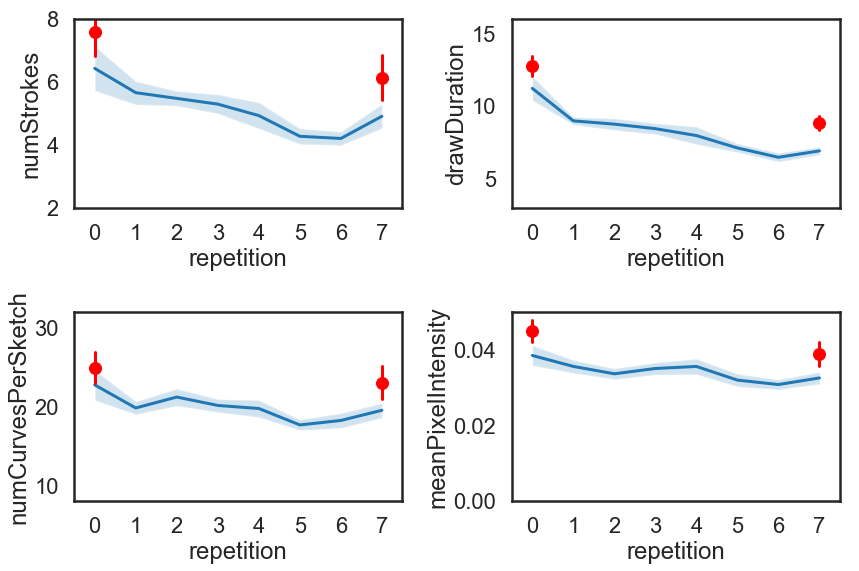

In [17]:
var0='numStrokes'
var1='drawDuration'
var2='numCurvesPerSketch'
var3= 'meanPixelIntensity'
h.ts_grid_repeated_control(D_normalized, 
                                                var0, var1, var2, var3,
                                                numReps=8,
                                                 save_plot=False,
                                                 plot_dir=plot_dir)

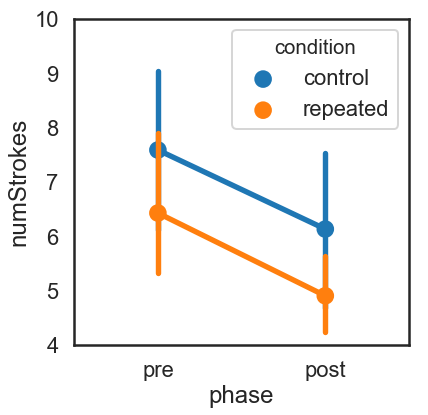

In [19]:
reload(h)
D1 = h.compare_conditions_prepost(D_normalized,
                                var='numStrokes',
                                lower_limit = 4,
                                upper_limit=10,
                                save_plot=False,
                                plot_dir=plot_dir)

##### seeing how previous trial accuracy affects numStrokes in the current trial

In [12]:
falseNumStrokes = []
trueNumStrokes = []
for i, d in D.iterrows():
    if (i != D.shape[0] - 1):
        if d['outcome'] == False:
            nextNumStrokes = D['outcome'][i+1]
            falseNumStrokes.append(nextNumStrokes)
        else:
            nextNumStrokes = D['outcome'][i+1]
            trueNumStrokes.append(nextNumStrokes)

In [13]:
meanNumStrokesGivenFalse = sum(falseNumStrokes)/float(len(falseNumStrokes))
meanNumStrokesGivenTrue =  sum(trueNumStrokes)/float(len(trueNumStrokes))
print meanNumStrokesGivenFalse, meanNumStrokesGivenTrue

0.843137254902 0.889175257732


In [14]:
## adding previous outcomes to each trial 
previousOutcome = []
previousOutcome.append('NaN')
for i, d in D.iterrows():
    if (i != D.shape[0] - 1):
        previousOutcome.append(d['outcome'])
D['previousOutcome'] = pd.Series(previousOutcome)

/Users/megumisano/graphical_conventions/analysis/python/analysis_helpers.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  X[column_id] = pd.to_numeric(X[column_id])
/Users/megumisano/anaconda/envs/py27/lib/python2.7/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)
/Users/megumisano/anaconda/envs/py27/lib/python2.7/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


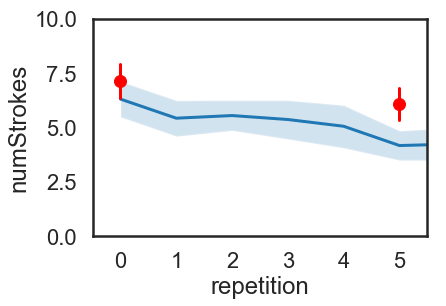

In [15]:
## conditioning on previous trial outcome being true 
D_true = D[D['previousOutcome'] == True]
reload(h)
dv = 'numStrokes'
h.ts_repeated_control(D_true, 
                        var=dv,
                        numReps = 6,
                        limit=10, # recommended limits: 'numStrokes' : 6, 'drawDuration' : 10, 'numCurvesPerSketch' : 20, 'numCurvesPerStroke' : 6 
                        save_plot=False,
                        plot_dir=plot_dir)

### confusion matrix for each category

In [108]:
reload(h)

<module 'analysis_helpers' from '/Users/megumisano/graphical_conventions/analysis/python/analysis_helpers.pyc'>

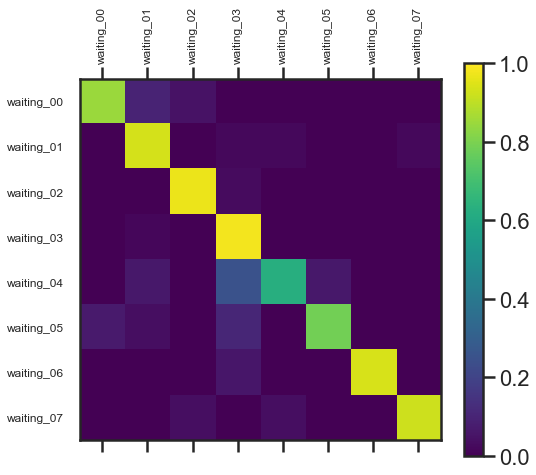

In [109]:
h.get_confusion_matrix(D, 'waiting', 4)

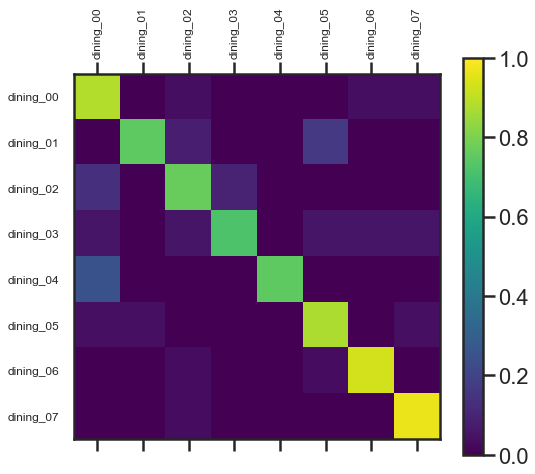

In [110]:
h.get_confusion_matrix(D, 'dining', 4)

##### confusion matrix for rep 0 and 7 

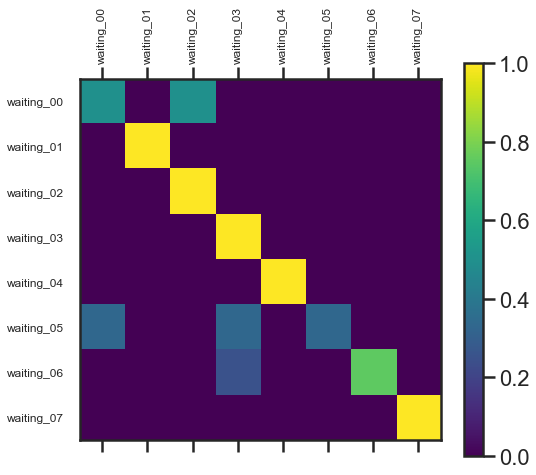

In [129]:
reload(h)
h.get_confusion_matrix_on_rep(D, 'waiting', 4, 0)

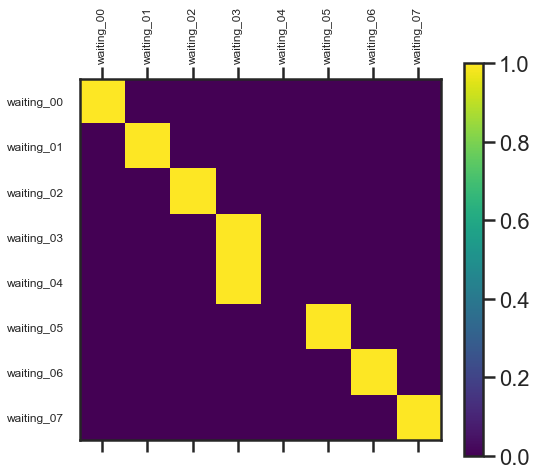

In [112]:
h.get_confusion_matrix_on_rep(D, 'waiting', 4, 7)

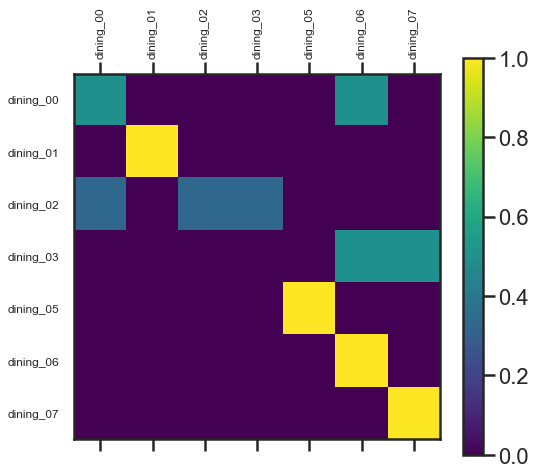

In [113]:
reload(h)
h.get_confusion_matrix_on_rep(D, 'dining', 4, 0)

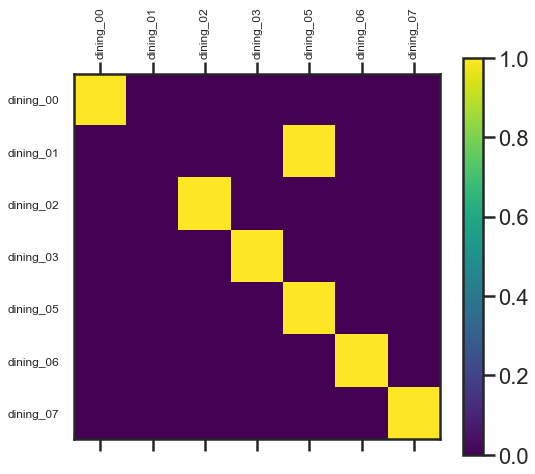

In [114]:
reload(h)
h.get_confusion_matrix_on_rep(D, 'dining', 4, 7)

## visualize behavioral measures over time

In [115]:
# reload analysis_helpers just to be on the safe side 
reload(h)

## set seaborn style params here
sns.set_context('poster')
sns.set_style('white')

##### Accuracy over time

In [130]:
total = 0
for outcome in D['outcome']:
    total = total + outcome 
meanAccuracy = total / len(D['outcome'])
meanAccuracy

0.884090909090909

([<matplotlib.axis.XTick at 0x1a1548f390>,
 <a list of 8 Text xticklabel objects>)

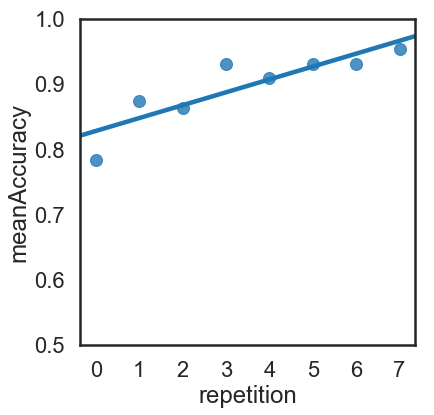

In [132]:
mean_accuracy_list = []
for i in range(0,8):
    outcome_list = (D.loc[D['repetition'] == i])['outcome']
    mean_accuracy = sum(outcome_list) / float(len(outcome_list))
    mean_accuracy_list.append(mean_accuracy)
D_mean = pd.DataFrame()
D_mean['meanAccuracy'] = mean_accuracy_list
D_mean['repetition'] = range(0,8)
D_mean
plt.figure(figsize=(6,6))
sns.regplot(data=D_mean,
         x='repetition',
         y='meanAccuracy',
         ci = None)    
plt.ylim([0.5,1.0])
plt.xticks(np.arange(0, 8, step=1))

### plot time series during repetition phase 

##### individual measures across reps (repeated trials only)

In [34]:
# What is the measure that you want to visualize across reps? 
dv = 'outcome'

In [25]:
# D0 = h.ts_repeated(D,
#                                     var=dv,
#                                     limit=20, # recommended limits: 'numStrokes' : 6, 'drawDuration' : 10, 'numCurvesPerSketch' : 20, 'numCurvesPerStroke' : 6 
#                                     save_plot=False,
#                                     plot_dir=plot_dir)

##### individual measures across reps (repeated + control)

/Users/megumisano/anaconda/envs/py27/lib/python2.7/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)
/Users/megumisano/anaconda/envs/py27/lib/python2.7/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


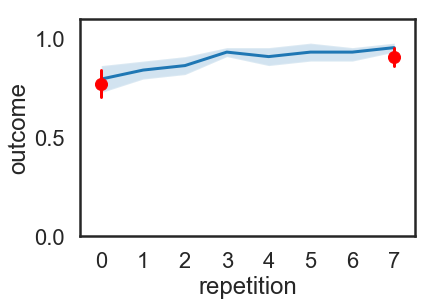

In [35]:
reload(h)
h.ts_repeated_control(D, 
                        var=dv,
                        numReps = 8,
                        limit=1.1, # recommended limits: 'numStrokes' : 6, 'drawDuration' : 10, 'numCurvesPerSketch' : 20, 'numCurvesPerStroke' : 6 
                        save_plot=False,
                        plot_dir=plot_dir)

##### 4 measures (2x2) across reps (repeated + control) 

In [120]:
# What are the four measures that you want to visualize across reps? 
var0='numStrokes'
var1='drawDuration'
var2='numCurvesPerSketch'
var3= 'meanPixelIntensity'

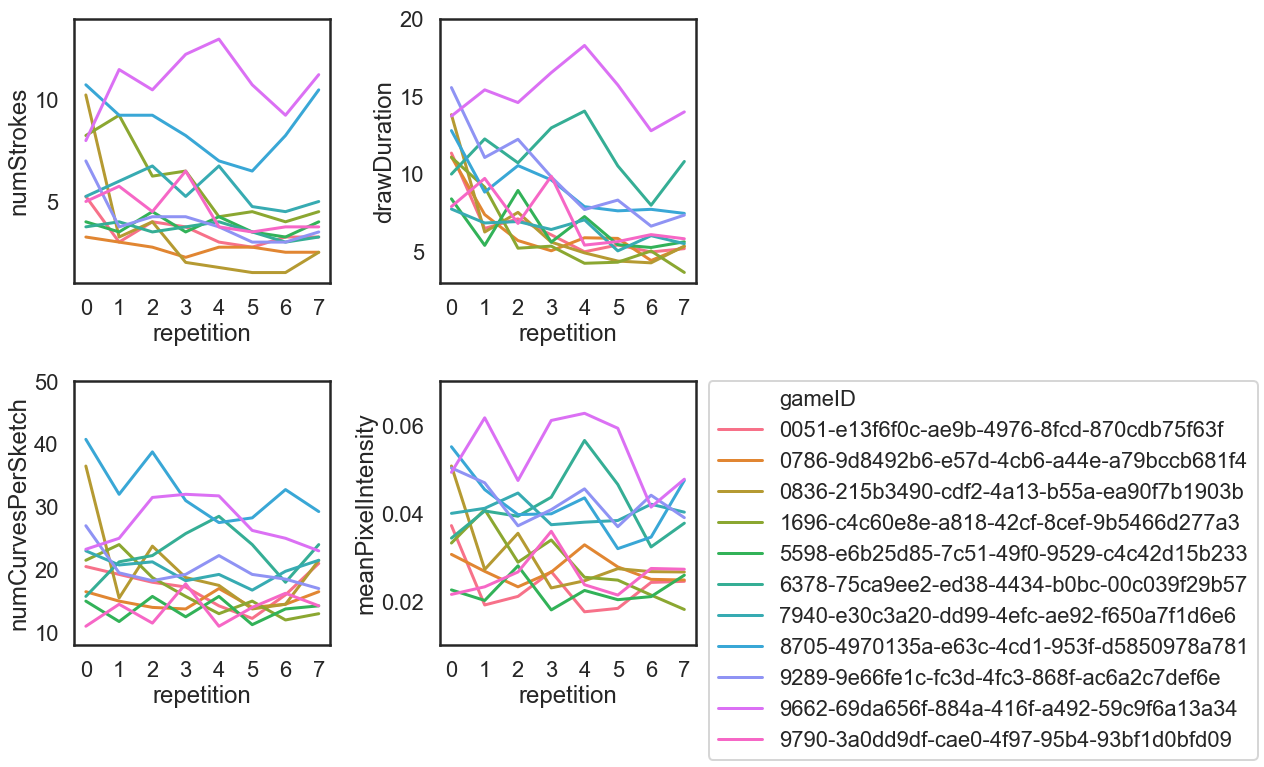

In [123]:
reload(h)
h.line_grid_individual(D, 
                                      var0, var1, var2, var3,
                                       numReps=8,
                                      save_plot=False,
                                      plot_dir=plot_dir)

In [94]:
# What are the four measures that you want to visualize across reps? 
var0='numStrokes'
var1='drawDuration'
var2='numCurvesPerSketch'
var3= 'meanPixelIntensity'

In [60]:
# ## making sure outcome is numeric 
# for i, o in enumerate(D['outcome']):
#     if o == True:
#         D.set_value(i, 'outcome', 1)
#     else:
#         D.set_value(i, 'outcome', 0)
# D['outcome'] = D['outcome'].astype(int)

/Users/megumisano/anaconda/envs/py27/lib/python2.7/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)
/Users/megumisano/anaconda/envs/py27/lib/python2.7/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)
/Users/megumisano/anaconda/envs/py27/lib/python2.7/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)
/Users/megumisano/anaconda/envs/py27/lib/python2.7/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future

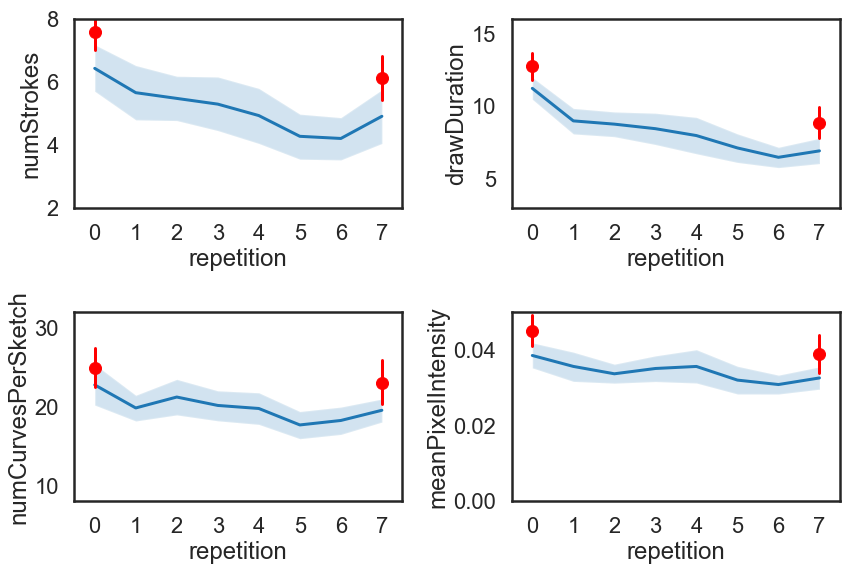

In [124]:
reload(h)
h.ts_grid_repeated_control(D, 
                                                var0, var1, var2, var3,
                                                numReps=8,
                                                 save_plot=False,
                                                 plot_dir=plot_dir)

### compare conditions in pre and post phases 

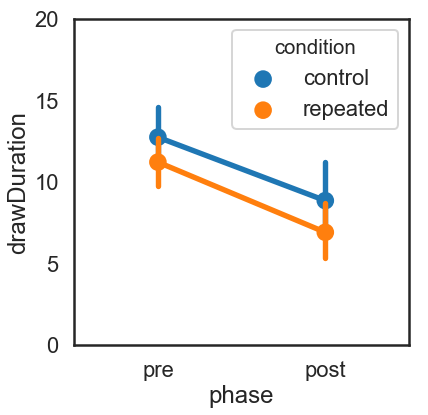

In [125]:
D1 = h.compare_conditions_prepost(D,
                                var='drawDuration',
                                limit=20,
                                save_plot=False,
                                plot_dir=plot_dir)

##### compare accuracy in pre and post phases (repeated vs control conditions)

In [127]:
for i, o in enumerate(D['outcome']):
    if o == True:
        D.set_value(i, 'outcome', 1)
    else:
        D.set_value(i, 'outcome', 0)
D['outcome'] = D['outcome'].astype(int)

/Users/megumisano/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:3: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  This is separate from the ipykernel package so we can avoid doing imports until


(0, 1.1)

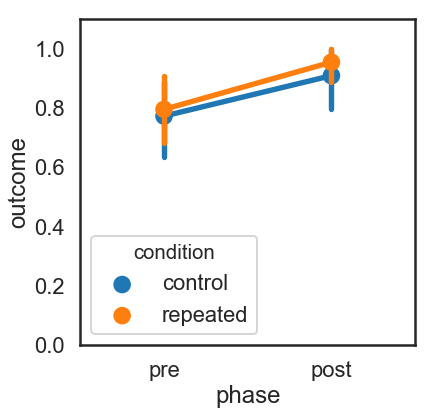

In [128]:
_D1 = D[D['phase']!='repeated'] ## exclude "repetition-phase" trials
D1 = _D1.groupby(['gameID','phase','condition'])['outcome'].mean()
D1 = D1.reset_index()    

plt.figure(figsize=(6,6))
sns.pointplot(data=D1,
         x='phase',
         y='outcome',
         hue='condition',
         order=['pre','post'])    
plt.ylim([0,1.1])
#plt.savefig(os.path.join(plot_dir,'timeseries_across_reps_{}.pdf'.format(var))) 
#return D1    

 ### visualize how sketches are changing across repetitions

##### printing actual sketches next to repeated sketches

Printing out sketches from game: 0836-215b3490-cdf2-4a13-b55a-ea90f7b1903b
Printing out sketches from game: 8705-4970135a-e63c-4cd1-953f-d5850978a781
Printing out sketches from game: 0051-e13f6f0c-ae9b-4976-8fcd-870cdb75f63f
Printing out sketches from game: 9790-3a0dd9df-cae0-4f97-95b4-93bf1d0bfd09
Printing out sketches from game: 9289-9e66fe1c-fc3d-4fc3-868f-ac6a2c7def6e
Printing out sketches from game: 0786-9d8492b6-e57d-4cb6-a44e-a79bccb681f4
Printing out sketches from game: 5598-e6b25d85-7c51-49f0-9529-c4c42d15b233
Printing out sketches from game: 6378-75ca9ee2-ed38-4434-b0bc-00c039f29b57
Printing out sketches from game: 7940-e30c3a20-dd99-4efc-ae92-f650a7f1d6e6
Printing out sketches from game: 1696-c4c60e8e-a818-42cf-8cef-9b5466d277a3


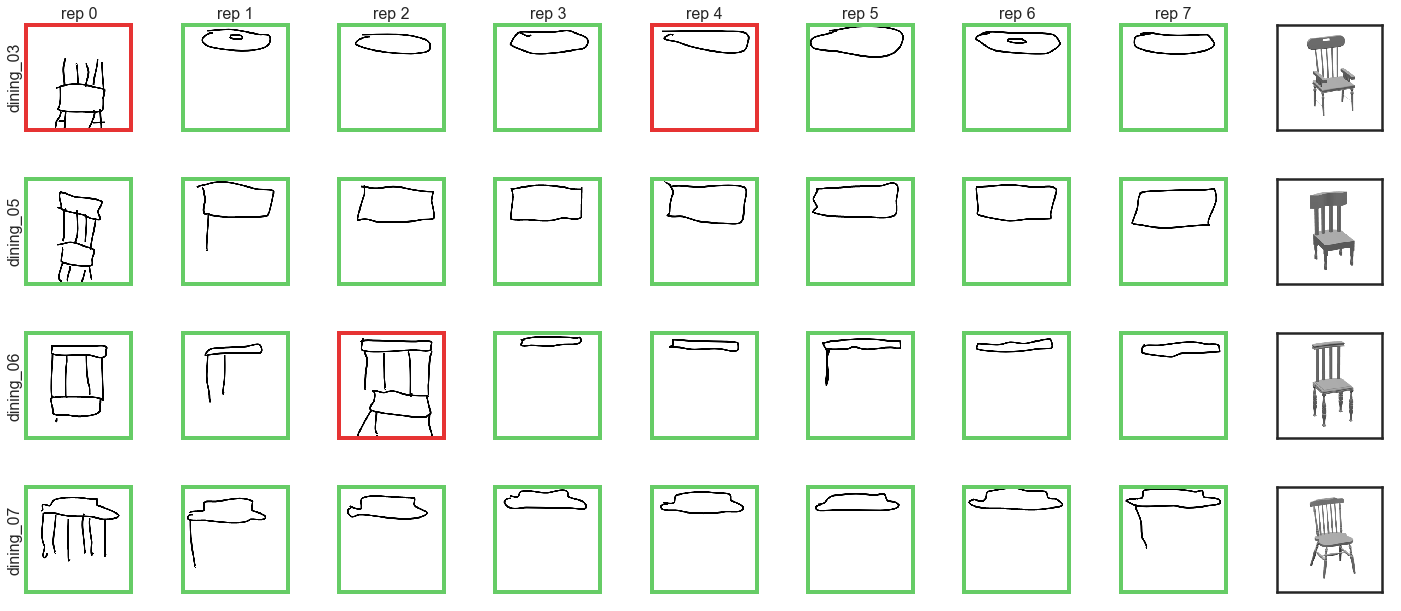

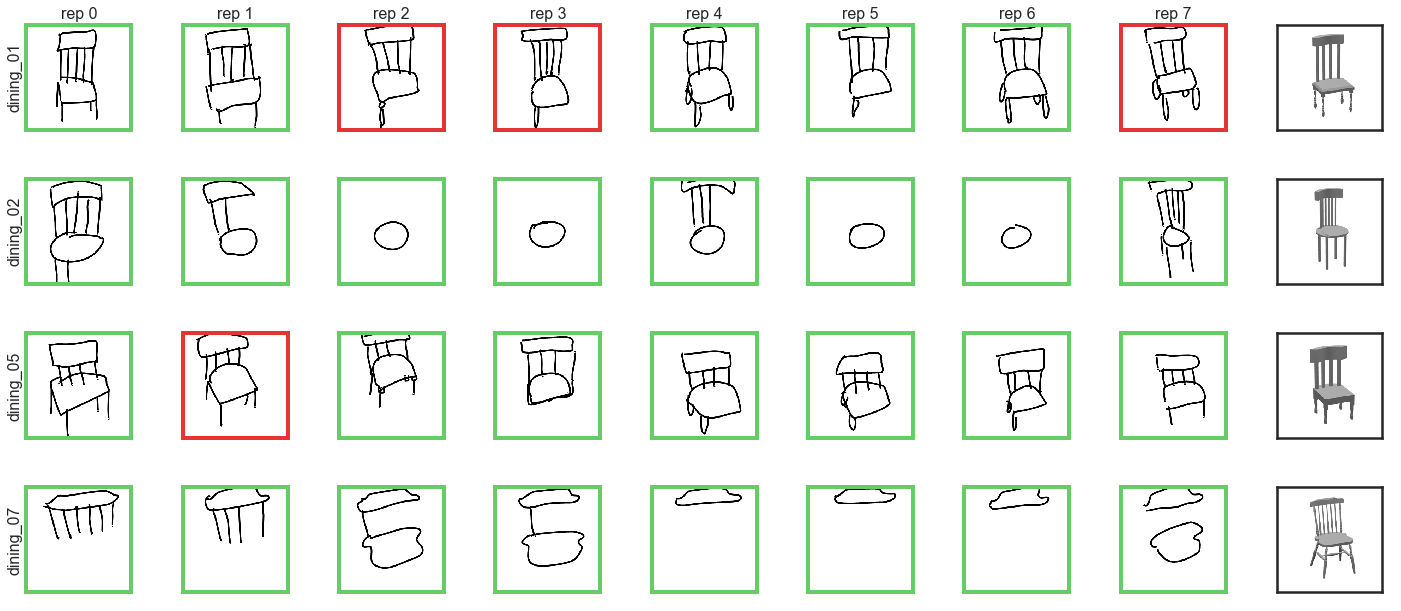

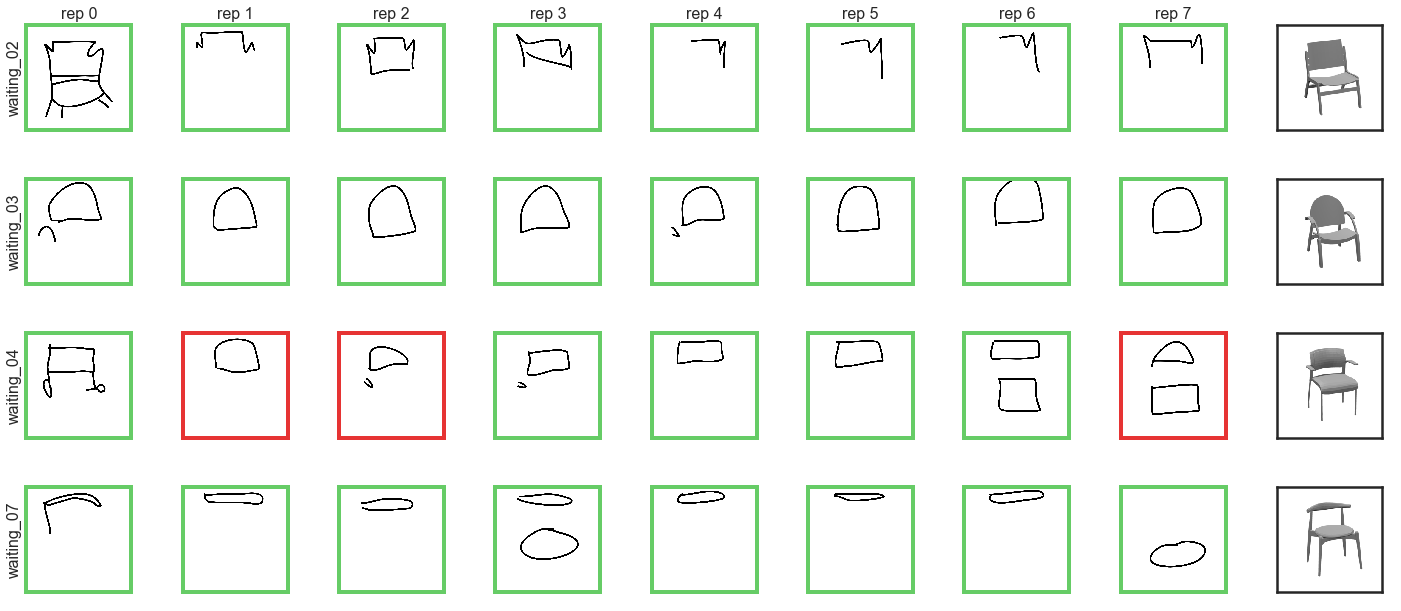

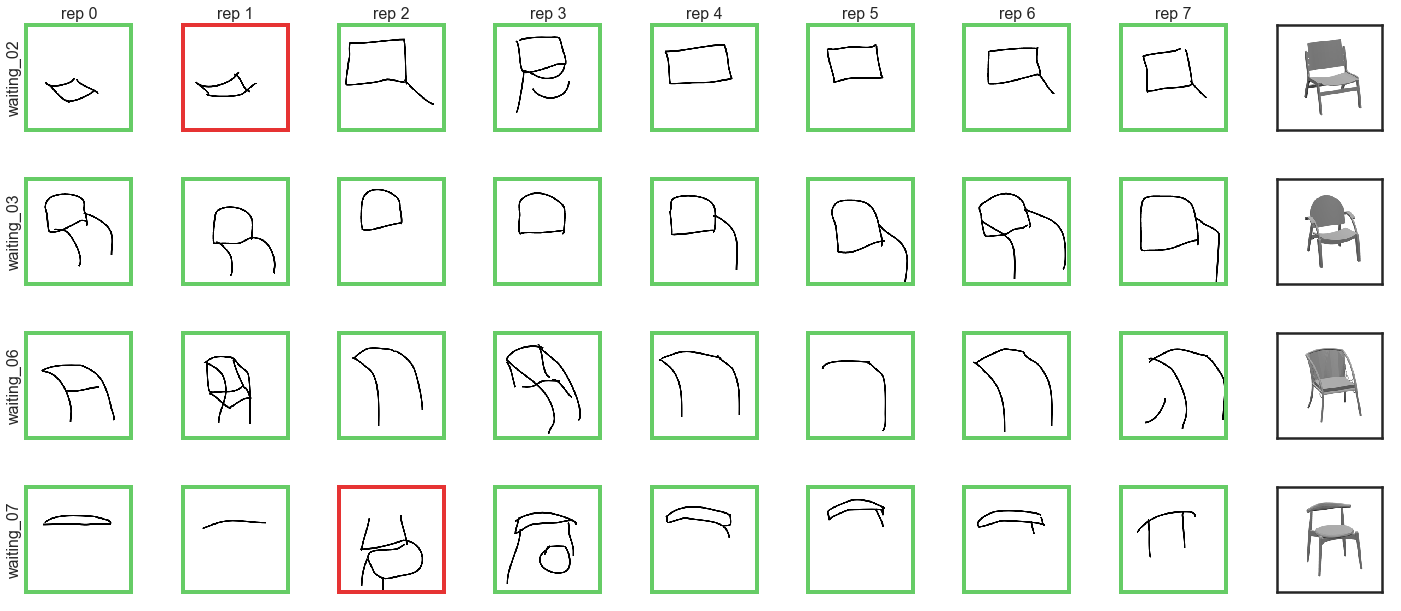

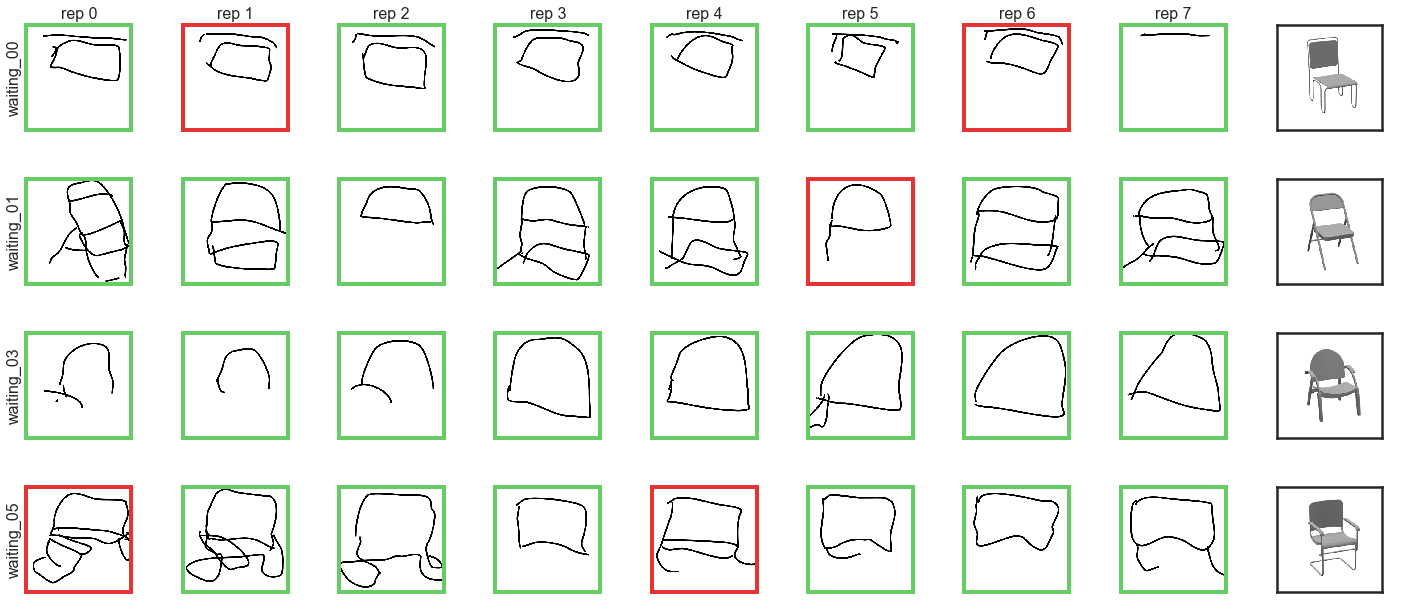

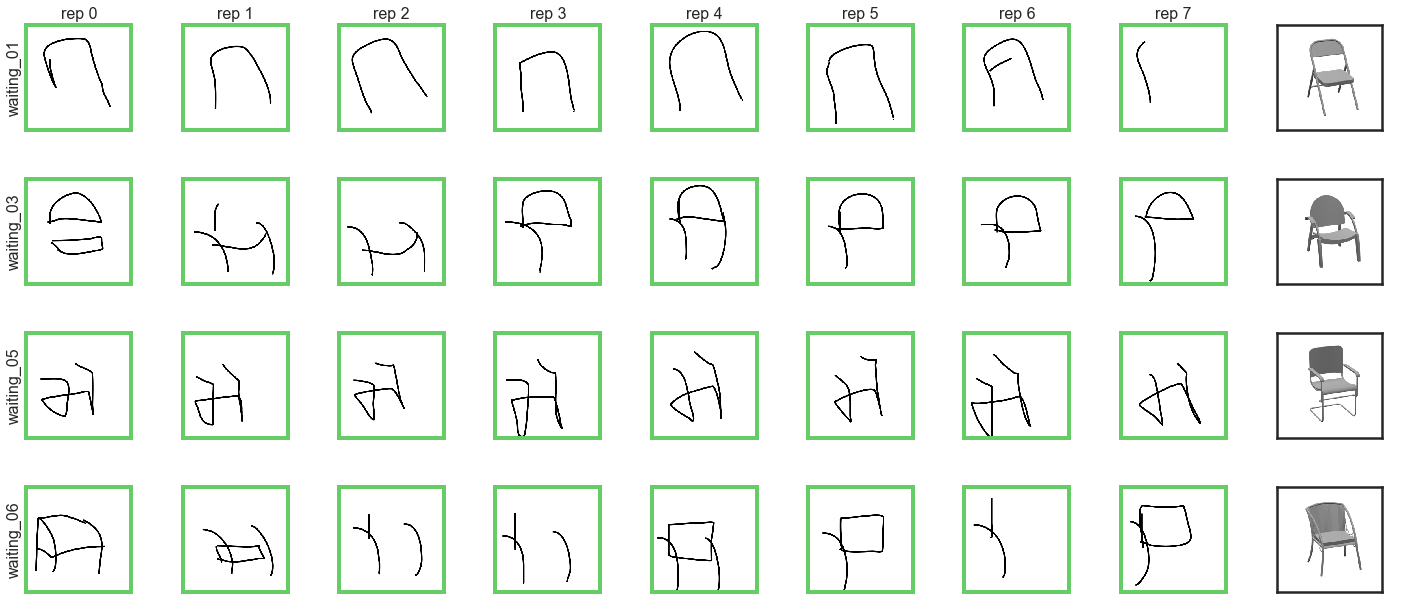

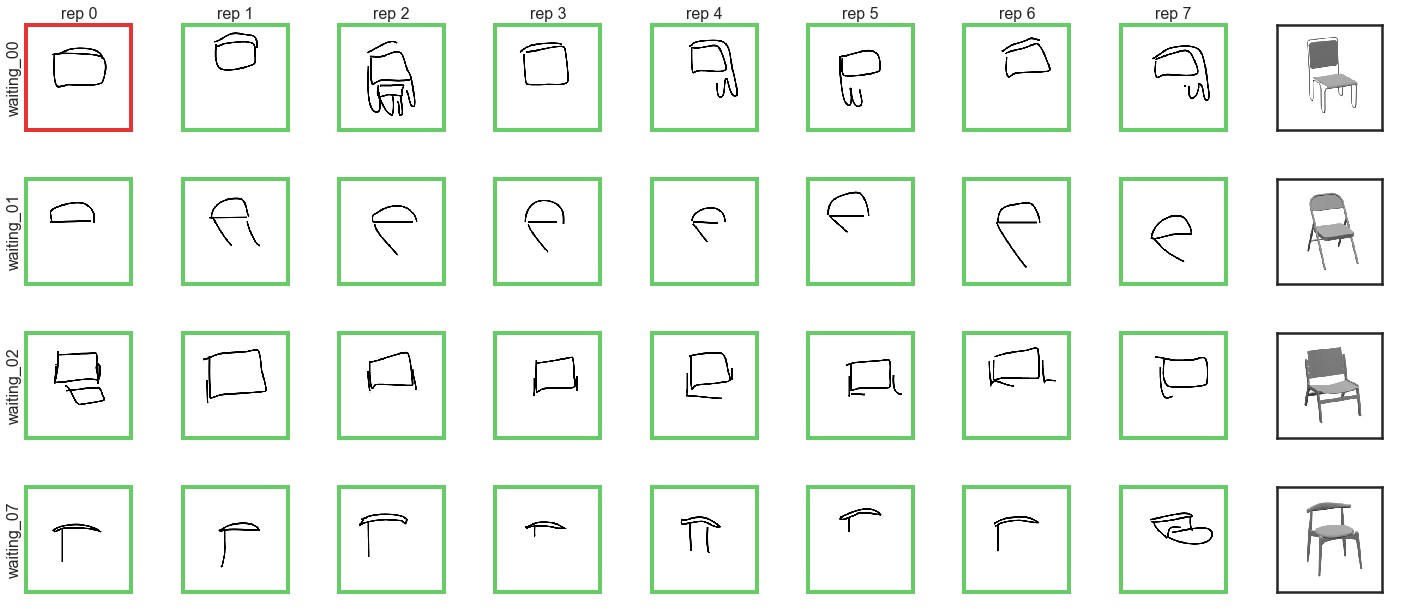

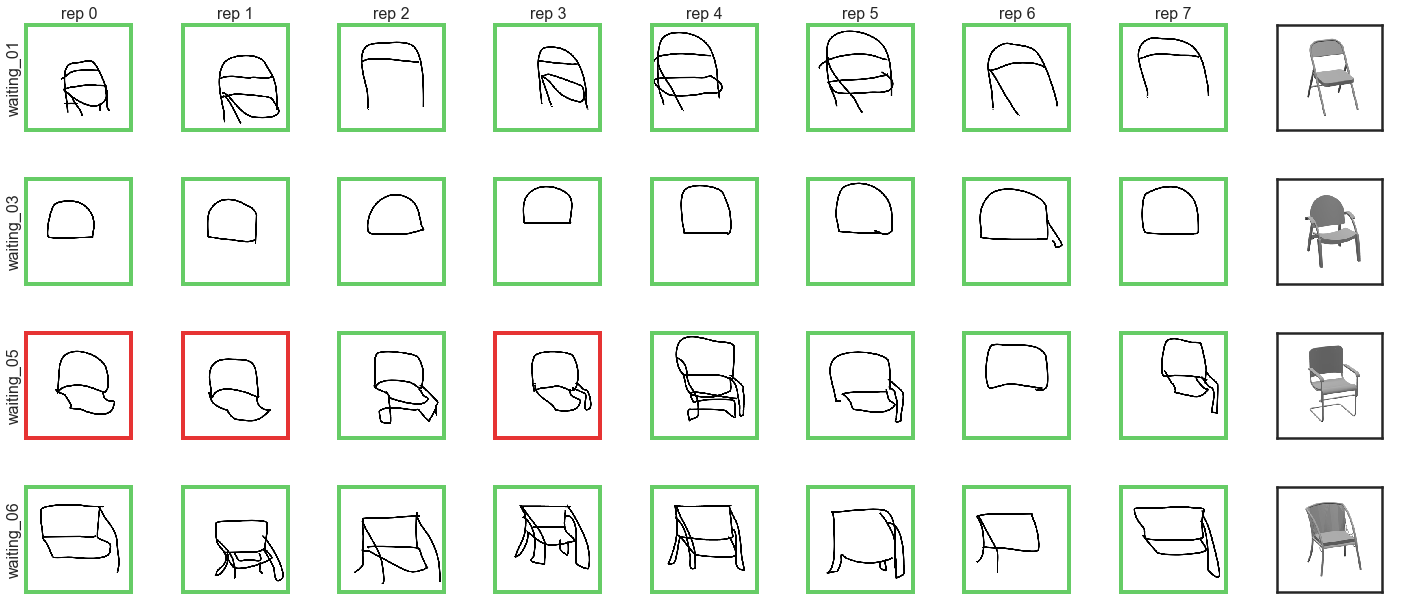

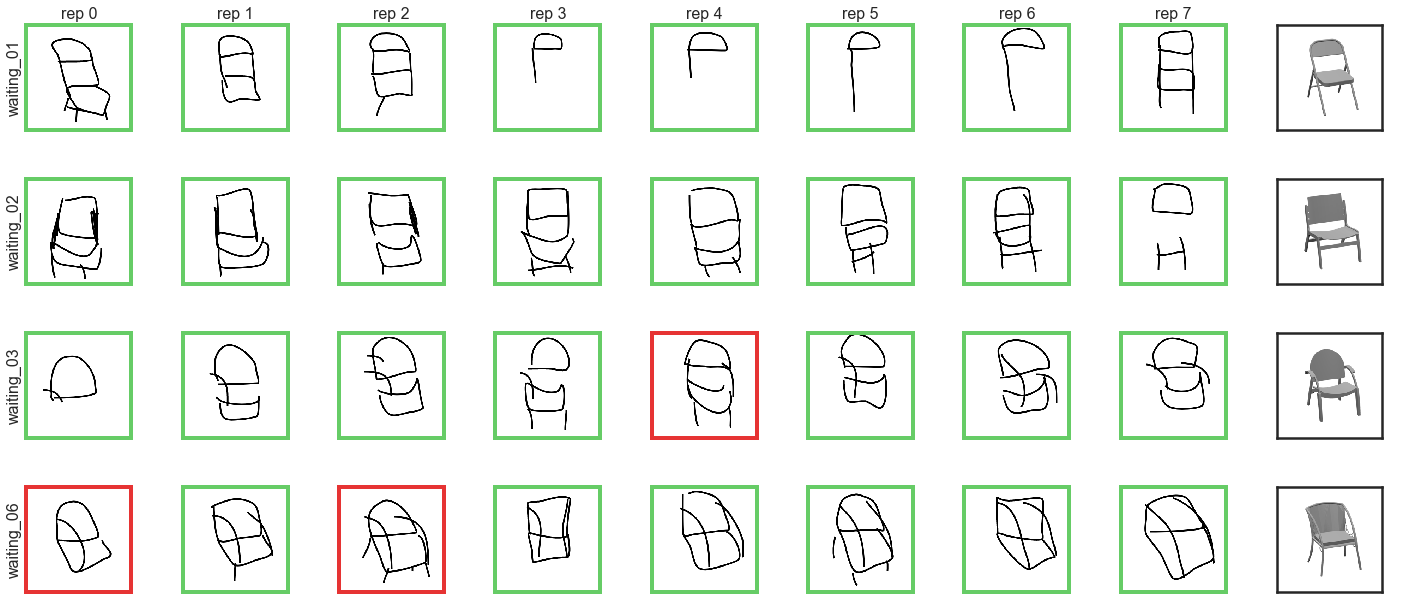

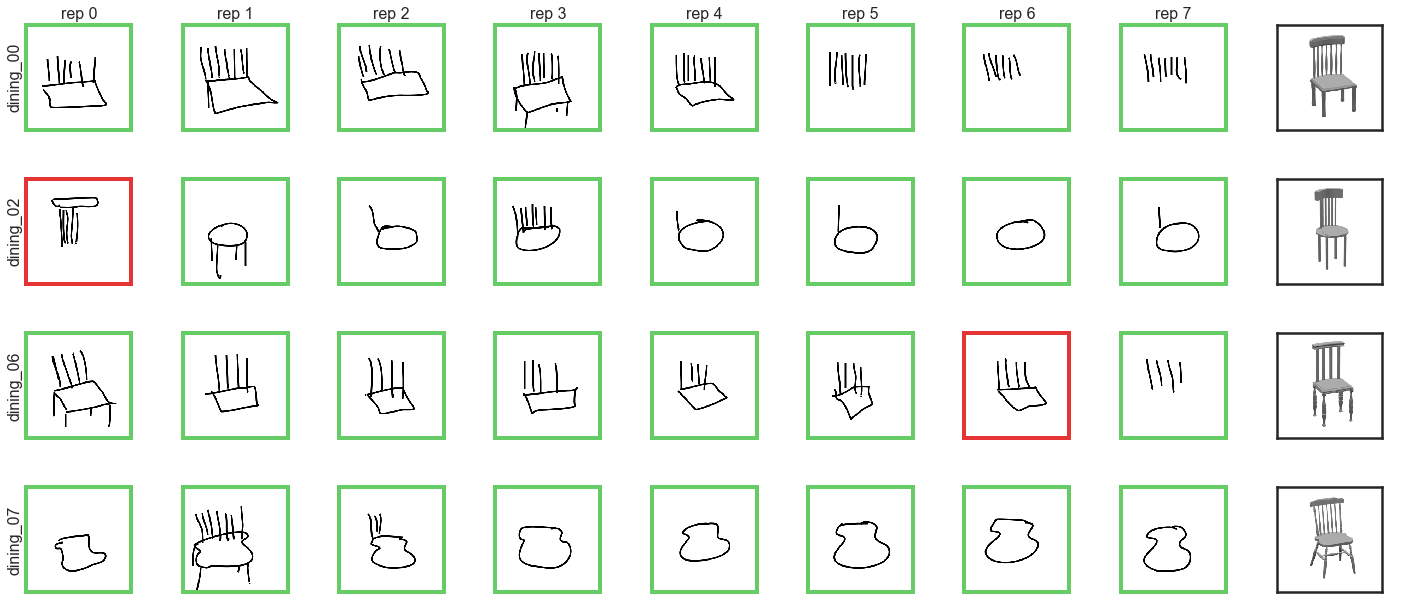

In [136]:
reload(h)
h.print_repeated_actual(D,
                                   _complete_games,
                                   4)

##### printing last sketch of control condition next to repeated sketches 

Printing out sketches from game: 0836-215b3490-cdf2-4a13-b55a-ea90f7b1903b
Printing out sketches from game: 8705-4970135a-e63c-4cd1-953f-d5850978a781
Printing out sketches from game: 0051-e13f6f0c-ae9b-4976-8fcd-870cdb75f63f
Printing out sketches from game: 9289-9e66fe1c-fc3d-4fc3-868f-ac6a2c7def6e
Printing out sketches from game: 0786-9d8492b6-e57d-4cb6-a44e-a79bccb681f4
Printing out sketches from game: 5598-e6b25d85-7c51-49f0-9529-c4c42d15b233
Printing out sketches from game: 6378-75ca9ee2-ed38-4434-b0bc-00c039f29b57
Printing out sketches from game: 7940-e30c3a20-dd99-4efc-ae92-f650a7f1d6e6
Printing out sketches from game: 1696-c4c60e8e-a818-42cf-8cef-9b5466d277a3
Printing out sketches from game: 9662-69da656f-884a-416f-a492-59c9f6a13a34


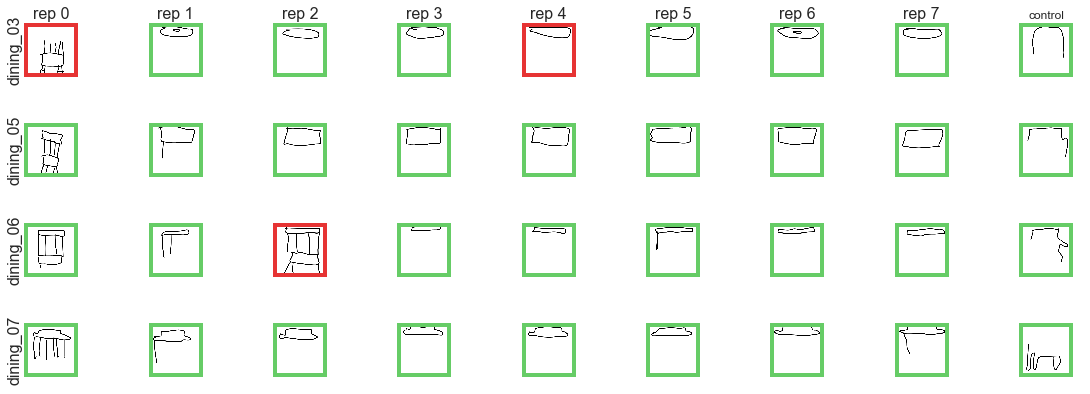

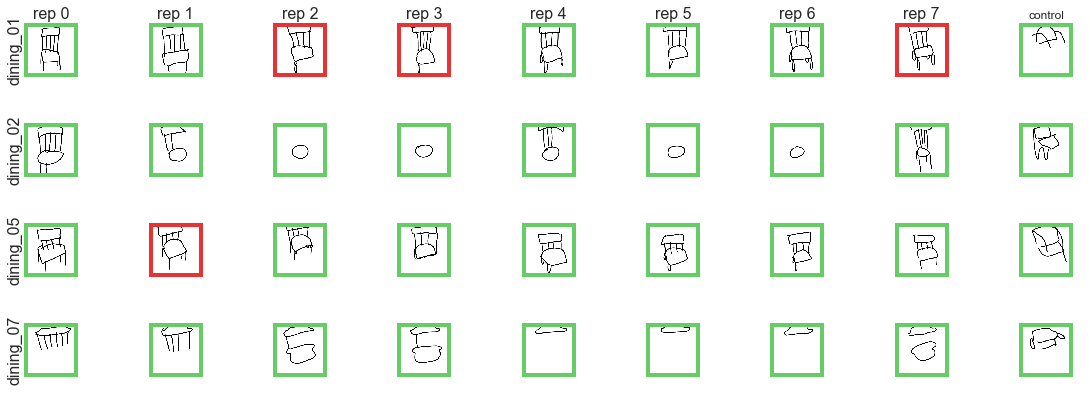

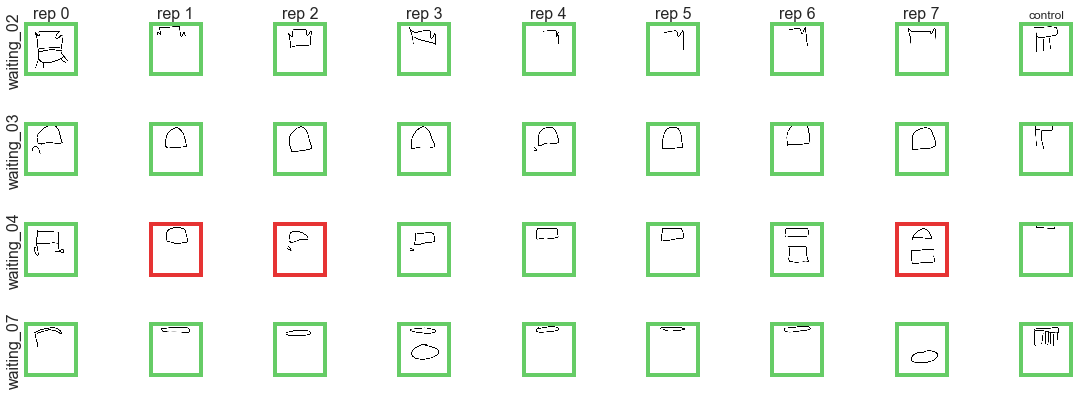

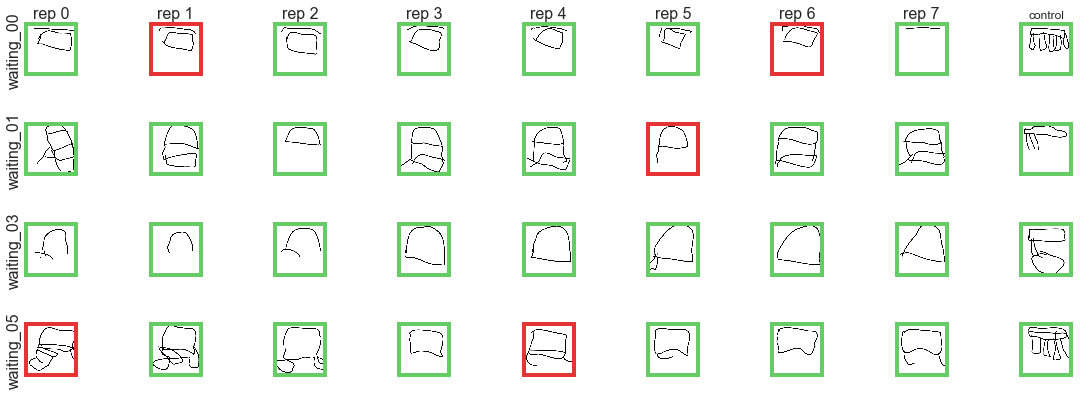

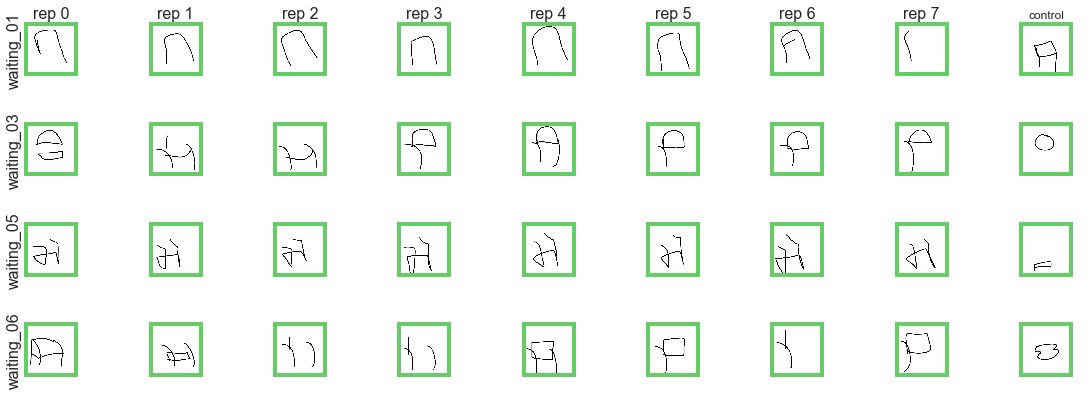

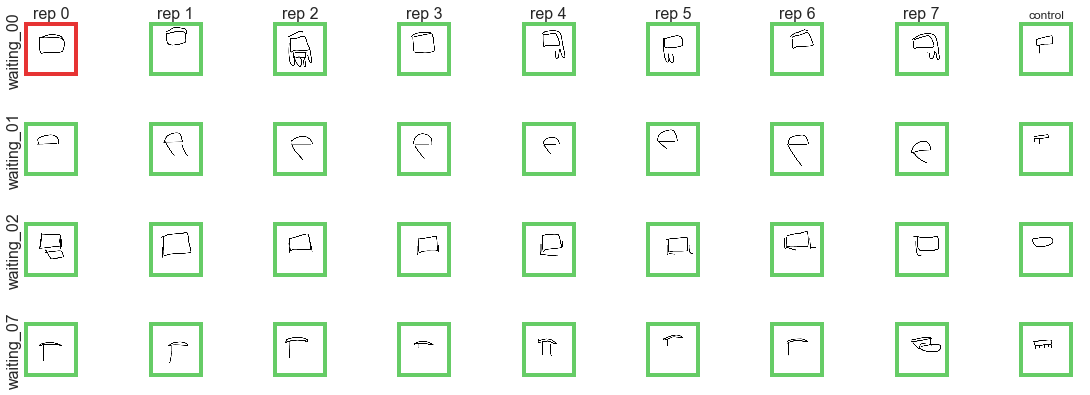

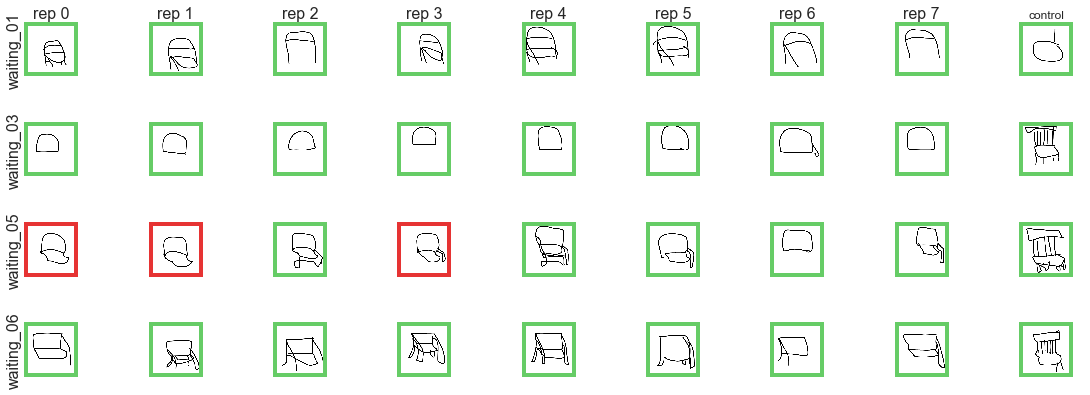

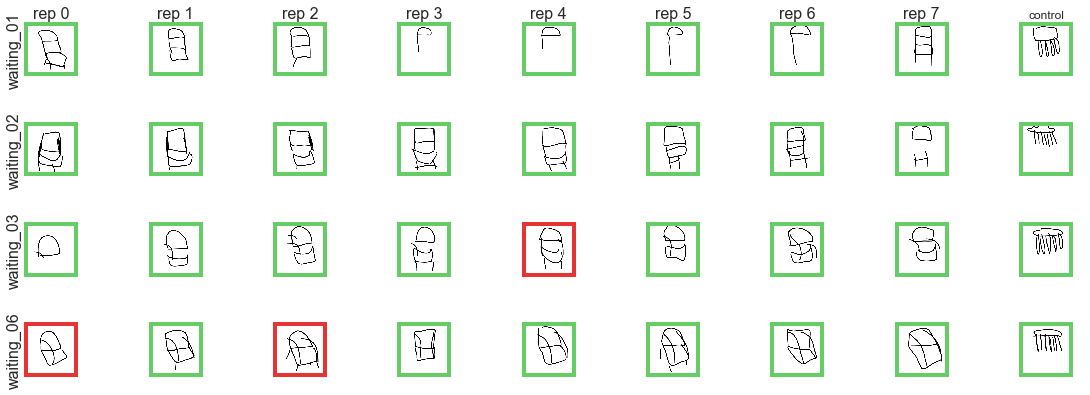

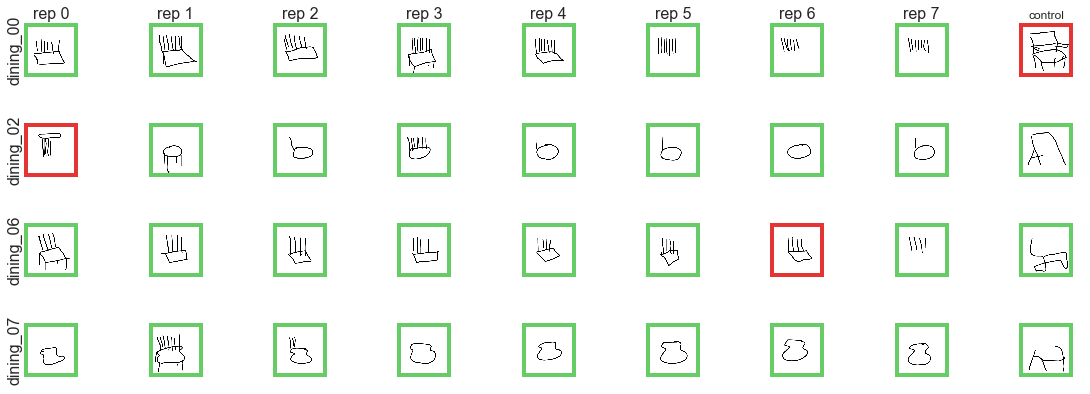

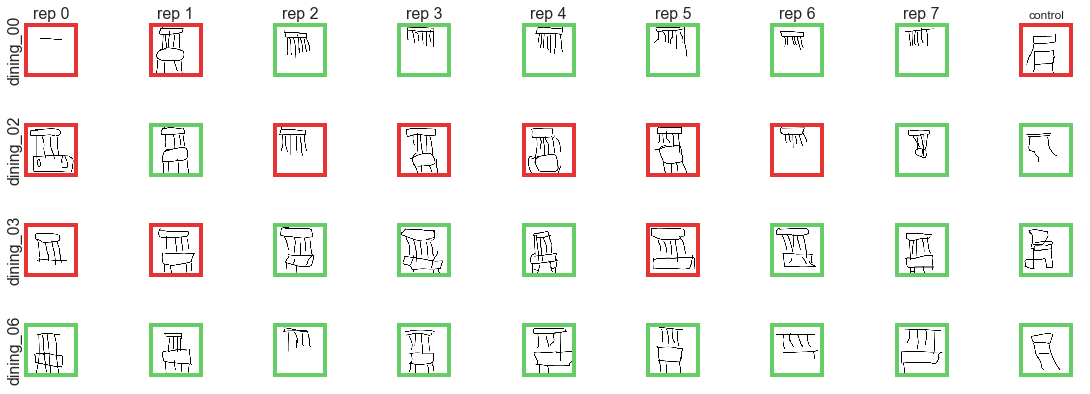

In [50]:
y = ['9790-3a0dd9df-cae0-4f97-95b4-93bf1d0bfd09'] ## broken png? 
_complete_games= [item for item in complete_games if item not in y]

reload(h)
h.print_repeated_control(D,
                                   _complete_games,
                                  4)

### WORKING AREA

In [ ]:
## collapsing across objects within repetition (within pair) 
D0_repeated = (D_repeated.groupby(['gameID','repetition','condition'])[var0].mean()).reset_index()
D1_repeated = (D_repeated.groupby(['gameID','repetition','condition'])[var1].mean()).reset_index()
D2_repeated = (D_repeated.groupby(['gameID','repetition','condition'])[var2].mean()).reset_index()
D3_repeated = (D_repeated.groupby(['gameID','repetition','condition'])[var3].mean()).reset_index()

D0_control = ((D_control.groupby(['gameID','repetition','condition'])[var0].mean()).reset_index()).replace(1, 7) # rescale control reps 
D1_control = ((D_control.groupby(['gameID','repetition','condition'])[var1].mean()).reset_index()).replace(1, 7) # rescale control reps 
D2_control = ((D_control.groupby(['gameID','repetition','condition'])[var2].mean()).reset_index()).replace(1, 7) # rescale control reps 
D3_control = ((D_control.groupby(['gameID','repetition','condition'])[var3].mean()).reset_index()).replace(1, 7) # rescale control reps 

In [ ]:

# sns.tsplot(data=D0_repeated,
#            time='repetition',
#            unit='gameID',
#            value=var0,
#            ax=ax0)

# sns.tsplot(data=D0_control,
#                time='repetition',
#                unit='gameID',
#                value=var0,
#                err_style='ci_bars',
#                interpolate=False,
#                ax=ax0,
#                color='r')

# sns.tsplot(data=D1_repeated,
#            time='repetition',
#            unit='gameID',
#            value=var1,
#            ax=ax1)

# sns.tsplot(data=D1_control,
#                time='repetition',
#                unit='gameID',
#                value=var1,
#                err_style='ci_bars',
#                interpolate=False,
#                ax=ax1,
#                color='r')

# sns.tsplot(data=D2_repeated,
#            time='repetition',
#            unit='gameID',
#            value=var2,
#            ax=ax2)

# sns.tsplot(data=D2_control,
#                time='repetition',
#                unit='gameID',
#                value=var2,
#                err_style='ci_bars',
#                interpolate=False,
#                ax=ax2,
#                color='r')

# sns.tsplot(data=D3_repeated,
#            time='repetition',
#            unit='gameID',
#            value=var3,
#            ax=ax3)

# sns.tsplot(data=D3_control,
#                time='repetition',
#                unit='gameID',
#                value=var3,
#                err_style='ci_bars',
#                interpolate=False,
#                ax=ax3,
#                color='r')

# plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
# ax0.set(xlim=(-0.5, 7.5), xticks=range(0,8))
# ax1.set(xlim=(-0.5, 7.5), xticks=range(0,8))
# ax2.set(xlim=(-0.5, 7.5), xticks=range(0,8))
# ax3.set(xlim=(-0.5, 7.5), xticks=range(0,8))

In [ ]:
# for i in range(0, 4):
#     var = 'var'+ i
#     print var
#     'D' + str(i) + '_' + condition = collapse_within_repetition(D, var, condition)

In [ ]:
def convert_numeric(X,column_id):
    ## make numeric types for aggregation
    X[column_id] = pd.to_numeric(X[column_id])
    return X

D = convert_numeric(convert_numeric(convert_numeric(convert_numeric(D,var0),var1),var2),var3) 

def collapse_within_repetition(D, var, condition):
    _D = D[D['condition']==condition]
    if condition == 'repeated':
        return (_D.groupby(['gameID','repetition','condition'])[var].mean()).reset_index()
    else: 
        return ((_D.groupby(['gameID','repetition','condition'])[var].mean()).reset_index()).replace(1,7)
    
def plot_repeated_control(D_repeated, D_control, var, ax):
    sns.tsplot(data=D_repeated,
           time='repetition',
           unit='gameID',
           value=var,
           ax=ax)

    sns.tsplot(data=D_control,
               time='repetition',
               unit='gameID',
               value=var,
               err_style='ci_bars',
               interpolate=False,
               ax=ax,
               color='r')
    
    ax.set(xlim=(-0.5, 7.5), xticks=range(0,8))

In [ ]:
_newD = pd.DataFrame()

target = d['target']
link = 'https://s3.amazonaws.com/shapenet-graphical-conventions/52f0514f5c38bc96f51f77a6d7299806.png'
extra_row = [link] * D.shape[1]
extra_df = pd.DataFrame(extra_row, index = list(D.columns.values))
extra_df = extra_df.transpose()
extra_df

_newD = pd.concat([_newD, extra_df])

In [ ]:
newD = pd.DataFrame()
for i, d in D.iterrows():
    d = d.to_frame()
    d = d.transpose()
    if i%6 == 0 & i != 0:
        newD = pd.concat([newD, d])
        target = d['target']
        link = 'https://s3.amazonaws.com/shapenet-graphical-conventions/52f0514f5c38bc96f51f77a6d7299806.png'
        extra_row = [link] * D.shape[1]
        extra_df = pd.DataFrame(extra_row, index = list(D.columns.values))
        extra_df = extra_df.transpose()
        newD = pd.concat([newD, extra_df])
    else:
        newD = pd.concat([newD, d])

# Miscellaneous

In [ ]:
#seaborn plotting

d = pd.DataFrame()
numReps = 7
variable = 'numStrokes'
# repeated conditions 
criteria_repeated = (D['condition']=='repeated')
repeated = D[criteria_repeated] # get all repeated condition trials 
repeats = list(range(0, numReps)) # number of repeats
repeated_means = []
for rep in repeats:
    mean = ((repeated[(repeated['repetition'] == rep)])[variable]).mean()  # get mean across trials with same repetition number
    repeated_means.append(mean)

# control conditions 
criteria_control = (D['condition']=='control')
control = D[criteria_control] # get all control condition trials 
controls = [0, numReps - 1] # number of controls scaled up to total number of repeats 
control_means= []
for i in [0, 1]: # only 2 controls, but should scale up to numReps 
    mean = ((control[(control['repetition'] == i)])[variable]).mean() # get mean across trials with same repetition number
    control_means.append(mean)

d['numReps'] = repeats
d[variable] = repeated_means
#d['control'] = control_means
facet = sns.lmplot(data=d, x='numReps', y=variable, fit_reg=False)
# add error bars 

In [ ]:
print repeated_strokes.mean(), control_strokes.mean()
print repeated_svgLength.mean(), control_svgLength.mean()
print repeated_svgStd.mean(), control_svgStd.mean()
print repeated_svgLengthPS.mean(), control_svgLengthPS.mean()
print repeated_drawDuration.mean(), control_drawDuration.mean()
print repeated_accuracy.mean(), control_accuracy.mean()

NameError: name 'control_strokes' is not defined

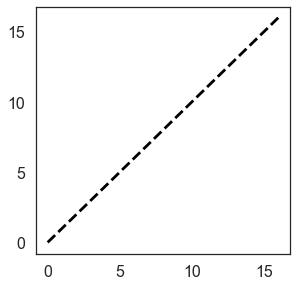

In [16]:
fig = plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
lb = 0
ub = 16
plt.plot([lb,ub],[lb,ub],'k--')
plt.scatter(control_strokes,repeated_strokes,64,(0.8,0.4,0.4))
plt.xlim([lb,ub])
plt.ylim([lb,ub])
plt.title('number of strokes')
plt.xlabel('control')
plt.ylabel('repeated')
plt.subplot(2,2,2)
lb = 0
ub = 3000
plt.plot([lb,ub],[lb,ub],'k--')
plt.scatter(control_svgLength,repeated_svgLength,64,(0.8,0.4,0.4))
plt.xlim([lb,ub])
plt.ylim([lb,ub])
plt.tight_layout()
plt.title('svg string length')
plt.xlabel('control')
plt.ylabel('repeated')
plt.subplot(2,2,3)
lb = 0
ub = 300
plt.plot([lb,ub],[lb,ub],'k--')
plt.scatter(control_svgStd,repeated_svgStd,64,(0.8,0.4,0.4))
plt.xlim([lb,ub])
plt.ylim([lb,ub])
plt.title('stroke variability')
plt.xlabel('control')
plt.ylabel('repeated')
plt.subplot(2,2,4)
lb = 0
ub = 600
plt.plot([lb,ub],[lb,ub],'k--')
plt.scatter(control_svgLengthPS,repeated_svgLengthPS,64,(0.8,0.4,0.4))
plt.xlim([lb,ub])
plt.ylim([lb,ub])
plt.tight_layout()
plt.title('svg length per stroke')
plt.xlabel('control')
plt.ylabel('repeated')

In [ ]:
a = coll.find({ '$and': [{'iterationName':iterationName}, {'eventType': 'clickedObj'}, {'time':{'$gt':1531160581750, '$lt': 1531161932801}}]}).sort('time')
for rec in a:
    print rec['phase'], rec['condition'],rec['repetition']